## Import general libraries

In [228]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [229]:
def show_correlation(df, size=(15,10)):
    corr = df.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(size[0], size[1])
    sns.heatmap(corr, annot=True)

In [230]:
# test = pd.read_csv("../input/titanic/test.csv")
# train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [231]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Encode Sex and Cabin column and fill missing Ages with negative numbers

In [232]:
print('Train')
print(train.isnull().sum())
print('==========================')
print('Test')
print(test.isnull().sum())

Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [233]:

train = train.fillna({'Age': -0.1})
test = test.fillna({'Age': -0.1})

#encode sex
sex_encoder = LabelEncoder()
sex_encoder.fit(['male', 'female'])
train['Sex'] = sex_encoder.transform(train['Sex'])
test['Sex'] = sex_encoder.transform(test['Sex'])


#encode cabin
train.loc[~train.Cabin.isnull(), 'Cabin'] = 1
train.loc[train.Cabin.isnull(), 'Cabin'] = 0

test.loc[~test.Cabin.isnull(), 'Cabin'] = 1
test.loc[test.Cabin.isnull(), 'Cabin'] = 0

#fill missed 'Embarked' values with max embarked places

#encode embarked feature
embarked_encoder = LabelEncoder()

#detect wich is a most common embarking place
common_embarked = train.groupby(['Embarked'])['Embarked'].value_counts().idxmax()[0]
train = train.fillna({'Embarked': common_embarked})
test = test.fillna({'Embarked': common_embarked})

# fill 'Fare' null values in test
test.loc[test.Fare.isnull(), 'Fare'] = 0

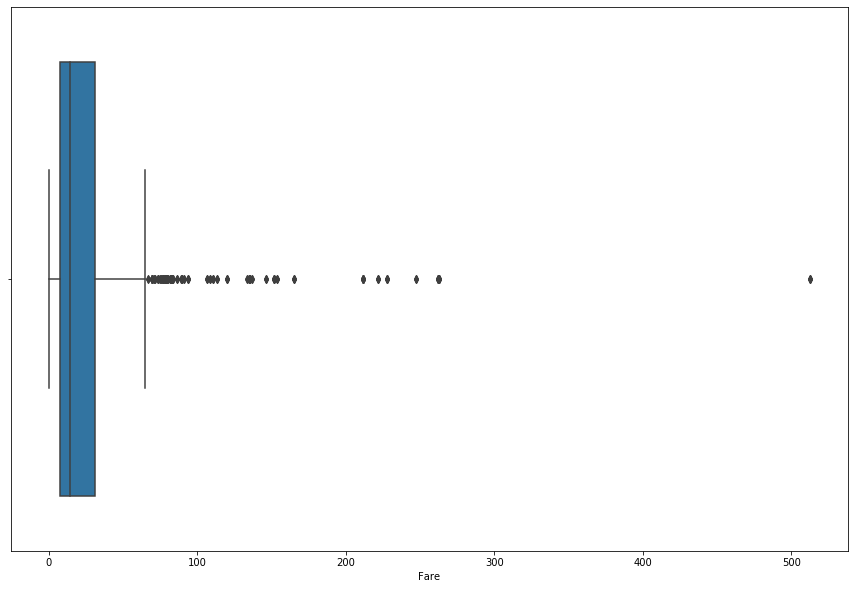

In [234]:
data_df = pd.concat([train, test])
fig,ax = plt.subplots()
fig.set_size_inches(15, 10)

sns.boxplot(data_df.Fare)

In [235]:
data_df[data_df.Fare > 300]['Fare'].count()

4

In [236]:
train = train[train.Fare < 300]

In [237]:
print('Train')
print(train.isnull().sum())
print('Test')
print(test.isnull().sum())

Train
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
Test
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Creating new column 'Title' derived from 'Name'

In [238]:
train['Title'] = train.Name.str.split(',', n=1, expand=True)[1].str.split('.',n=1, expand=True)[0]
train['Title'] = train.Title.str.strip()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr


In [239]:
test['Title'] = test.Name.str.split(',', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
test['Title'] = test.Title.str.strip()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,Q,Mr
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,S,Mrs


## Group Titles ('Mr', 'Miss', 'Mrs', 'Master', 'Other')

In [240]:
train.loc[train.Title == 'Ms', 'Title'] = 'Miss'
test.loc[test.Title == 'Ms', 'Title'] = 'Miss'

train.loc[~train.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
test.loc[~test.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'

## Encode grouped Titles

In [241]:
# title_encoder = LabelEncoder()
# title_encoder.fit(['Mr', 'Miss', 'Mrs', 'Master', 'Other'])

# train['Title'] = title_encoder.transform(train['Title'])
# test['Title'] = title_encoder.transform(test['Title'])

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr


In [242]:
train['FareGroup'] = pd.cut(train.Fare, [-0.1, 30, 70, 100, np.inf], labels=['very cheap', 'cheap', 'normal', 'expensive'])
test['FareGroup']= pd.cut(test.Fare, [-0.1, 30, 70, 100, np.inf], labels=['very cheap', 'cheap', 'normal', 'expensive'])

In [243]:
def fg_encoder(fg):
    encoder = {
        'very cheap': 0,
        'cheap': 1,
        'normal': 2,
        'expensive': 3   
    }
    return encoder.get(fg)


train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,very cheap
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,normal
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,very cheap
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,cheap
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,very cheap


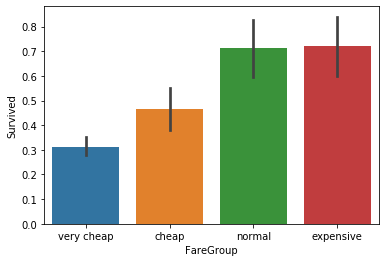

In [244]:
sns.barplot(x='FareGroup', y='Survived', data=train)

In [245]:
fare_dummies = pd.get_dummies(train.FareGroup)[['normal', 'expensive']]
fare_dummies.columns = ['NormalTicket', 'ExpensiveTicket']
train = train.join(fare_dummies)
train.drop(['FareGroup'], axis=1, inplace=True)

fare_dummies = pd.get_dummies(test.FareGroup)[['normal', 'expensive']]
fare_dummies.columns = ['NormalTicket', 'ExpensiveTicket']
test = test.join(fare_dummies)
test.drop(['FareGroup'], axis=1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NormalTicket,ExpensiveTicket
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,Mr,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,Mrs,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,Mr,0,0


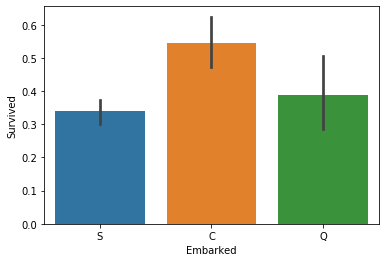

In [246]:
sns.barplot(x='Embarked', y='Survived', data=train)

In [247]:
embarked_dummies = pd.get_dummies(train.Embarked)[['C']]
train = train.join(embarked_dummies)
train.drop(['Embarked'], axis=1, inplace=True)

embarked_dummies = pd.get_dummies(test.Embarked)[['C']]
test = test.join(embarked_dummies)
test.drop(['Embarked'], axis=1, inplace=True)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,NormalTicket,ExpensiveTicket,C
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,Mr,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,Mrs,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,Miss,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,Mrs,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,Mr,0,0,0


In [251]:
sns.barplot(x='Title', y='Survived', data=train)

ValueError: Could not interpret input 'Title'

In [252]:
title_dummies = pd.get_dummies(train.Title)[['Mrs', 'Miss', 'Master']]

train = train.join(title_dummies)
train.drop(['Title'], axis=1, inplace=True)

title_dummies = pd.get_dummies(test.Title)['Mrs', 'Miss', 'Master']
test = test.join(title_dummies)
test.drop(['Title'], axis=1, inplace=True)

train.head()


AttributeError: 'DataFrame' object has no attribute 'Title'

In [254]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,NormalTicket,ExpensiveTicket,C,Mrs,Miss,Master
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,1,0,1,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,0,0,0,0,0


In [255]:
train['Alone'] = ((train.Parch + train.SibSp) == 0).astype(int)
test['Alone'] = ((test.Parch + test.SibSp) == 0).astype(int)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,NormalTicket,ExpensiveTicket,C,Mrs,Miss,Master,Alone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,1,0,1,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,0,0,0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,0,0,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,0,0,0,0,0,1


In [256]:
train = train.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Fare'], axis=1)
test = test.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Fare'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Cabin,NormalTicket,ExpensiveTicket,C,Mrs,Miss,Master,Alone
0,1,0,3,1,22.0,0,0,0,0,0,0,0,0
1,2,1,1,0,38.0,1,1,0,1,1,0,0,0
2,3,1,3,0,26.0,0,0,0,0,0,1,0,1
3,4,1,1,0,35.0,1,0,0,0,1,0,0,0
4,5,0,3,1,35.0,0,0,0,0,0,0,0,1


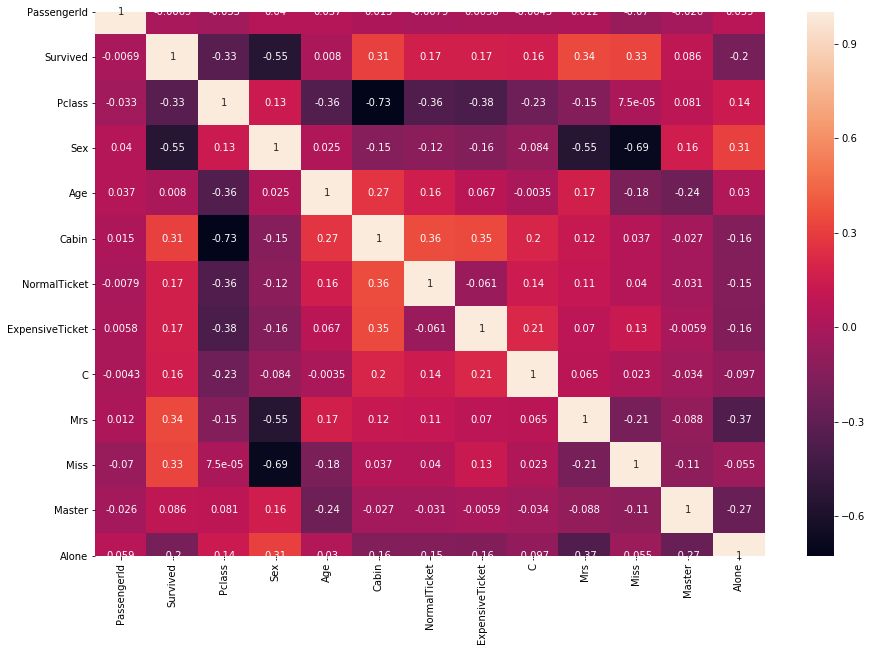

In [257]:
show_correlation(train)

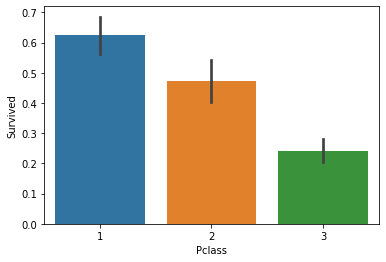

In [261]:
sns.barplot(x='Pclass', y='Survived', data=train)

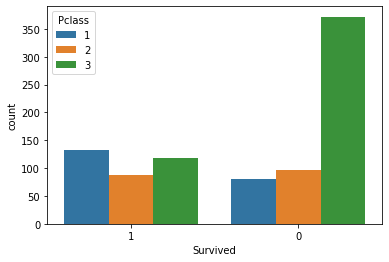

In [264]:
sns.countplot(x='Survived', hue="Pclass", data=train, order=[1,0])

In [277]:
class_dummies = pd.get_dummies(train.Pclass)
class_dummies.columns = ['Class1', 'Class2', 'Class3']
class_dummies.drop(['Class3'], axis=1, inplace=True)

train = train.join(class_dummies)
train.drop(['Pclass'], axis=1, inplace=True)

class_dummies = pd.get_dummies(test.Pclass)
class_dummies.columns = ['Class1', 'Class2', 'Class3']
class_dummies.drop(['Class3'], axis=1, inplace=True)

test = test.join(class_dummies)
test.drop(['Pclass'], axis=1, inplace=True)

train.head()


,PassengerId,Survived,Sex,Age,Cabin,NormalTicket,ExpensiveTicket,C,Mrs,Miss,Master,Alone,Class1,Class2
0,1,0,1,22.0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,38.0,1,1,0,1,1,0,0,0,1,0
2,3,1,0,26.0,0,0,0,0,0,1,0,1,0,0
3,4,1,0,35.0,1,0,0,0,1,0,0,0,1,0
4,5,0,1,35.0,0,0,0,0,0,0,0,1,0,0


## Unite train and test data to predict missing 'Age'-s

In [278]:
df = pd.concat([train, test])
df.isnull().sum()

Age                  0
Alone                0
C                    0
Cabin                0
Class1               0
Class2               0
ExpensiveTicket      0
Master             418
Miss               418
Mrs                418
NormalTicket         0
PassengerId          0
Sex                  0
Survived           418
Title              888
dtype: int64

## Remove unnecessary columns for predicting missing 'Age' values

In [279]:
df = df.drop(['PassengerId', 'Survived','Title'], axis=1)
df.head()

,Age,Alone,C,Cabin,Class1,Class2,ExpensiveTicket,Master,Miss,Mrs,NormalTicket,Sex
0,22.0,0,0,0,0,0,0,0.0,0.0,0.0,0,1
1,38.0,0,1,1,1,0,0,0.0,0.0,1.0,1,0
2,26.0,1,0,0,0,0,0,0.0,1.0,0.0,0,0
3,35.0,0,0,1,1,0,0,0.0,0.0,1.0,0,0
4,35.0,1,0,0,0,0,0,0.0,0.0,0.0,0,1


## Check out correlation matrix as heatmap

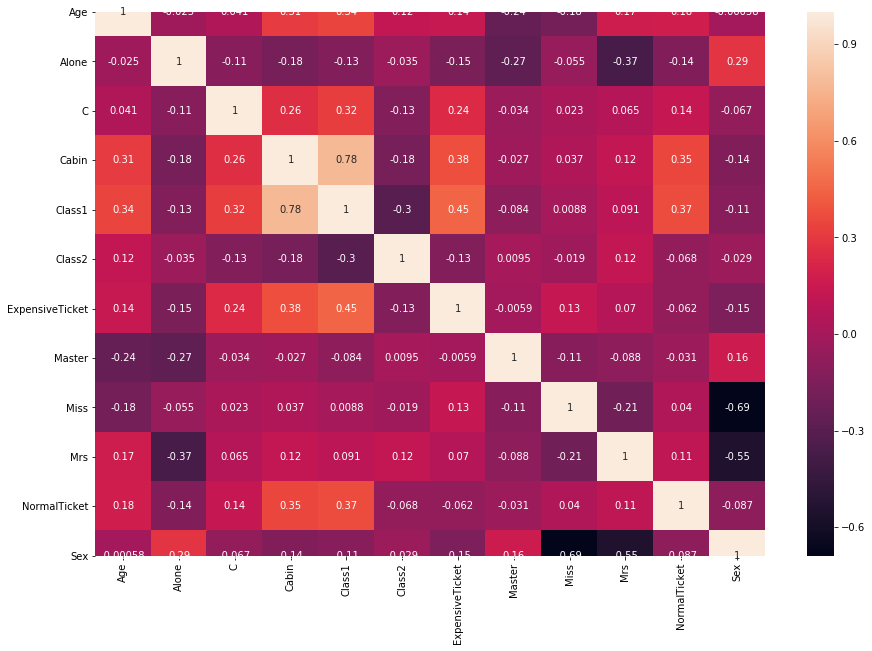

In [280]:
show_correlation(df)

## Prepare predictors and targets

In [281]:
predictors = df[df.Age > 0].drop(['Age'], axis=1)
targets = df[df.Age > 0]['Age']

predictors.head()

,Alone,C,Cabin,Class1,Class2,ExpensiveTicket,Master,Miss,Mrs,NormalTicket,Sex
0,0,0,0,0,0,0,0.0,0.0,0.0,0,1
1,0,1,1,1,0,0,0.0,0.0,1.0,1,0
2,1,0,0,0,0,0,0.0,1.0,0.0,0,0
3,0,0,1,1,0,0,0.0,0.0,1.0,0,0
4,1,0,0,0,0,0,0.0,0.0,0.0,0,1


In [289]:
test.isnull().sum()

PassengerId        0
Sex                0
Age                0
Cabin              0
Title              0
NormalTicket       0
ExpensiveTicket    0
C                  0
Alone              0
Class1             0
Class2             0
dtype: int64

In [282]:
scaler = StandardScaler()
predictors = scaler.fit_transform(predictors)

In [283]:
#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Predict ages using Multi Layer Perceptron

In [284]:
mlp = MLPRegressor(hidden_layer_sizes=(143, ))
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mean_squared_error(y_pred, y_test), mean_squared_error(mlp.predict(x_train), y_train), mlp

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

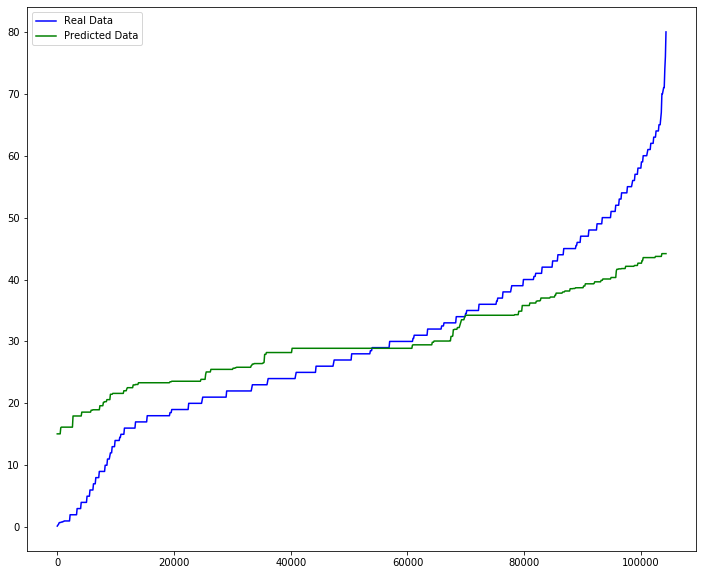

In [106]:
real_data = np.sort(np.concatenate((y_train, y_test)))
predicted_data = np.sort(np.concatenate((mlp.predict(x_train), mlp.predict(x_test))))

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), real_data, color='b', label='Real Data')
plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), predicted_data, color='g', label='Predicted Data')

plt.legend()

In [109]:
train.loc[train.Age < 0, 'Age'] = mlp.predict(scaler.transform(train[train['Age'] < 0][['Alone', 'Cabin', 'Embarked', 'FareGroup', 'Pclass', 'Sex']]))
test.loc[test.Age < 0, 'Age'] = mlp.predict(scaler.transform(test[test['Age'] < 0][['Alone', 'Cabin', 'Embarked', 'FareGroup', 'Pclass', 'Sex']]))

## Show age distribution

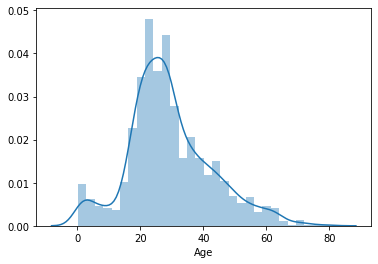

In [110]:
sns.distplot(pd.concat([train, test])['Age'])


In [114]:
pd.concat([train, test]).head()


,Age,Alone,Cabin,Embarked,FareGroup,PassengerId,Pclass,Sex,Survived,Title
0,22.0,0,0,2,0,1,3,1,0.0,4
1,38.0,0,1,0,2,2,1,0,1.0,4
2,26.0,1,0,2,0,3,3,0,1.0,4
3,35.0,0,1,2,1,4,1,0,1.0,4
4,35.0,1,0,2,0,5,3,1,0.0,4


In [124]:
train['AgeGroup'] = pd.cut(train.Age, [0, 16, 21, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
test['AgeGroup'] = pd.cut(test.Age, [0, 16, 21, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Cabin,Embarked,Title,FareGroup,Alone,AgeGroup
0,1,0,3,1,22.0,0,2,4,0,0,2
1,2,1,1,0,38.0,1,0,4,2,0,2
2,3,1,3,0,26.0,0,2,4,0,1,2
3,4,1,1,0,35.0,1,2,4,1,0,2
4,5,0,3,1,35.0,0,2,4,0,1,2


In [127]:
train.drop(['Age'], axis=1, inplace=True)
test.drop(['Age'], axis=1, inplace=True)

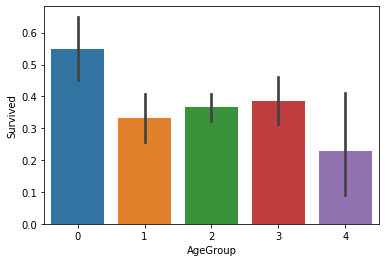

In [128]:
sns.barplot(x='AgeGroup', y='Survived', data=train)

In [141]:

train.loc[train.Sex == 1, 'Person'] = 'man'
test.loc[test.Sex == 1, 'Person'] = 'man'
train.loc[train.Sex == 0, 'Person'] = 'woman'
test.loc[test.Sex == 0, 'Person'] = 'woman'
train.loc[train.AgeGroup == 0, 'Person'] = 'child'
test.loc[test.AgeGroup == 0, 'Person'] = 'child'
train.head()

,PassengerId,Survived,Pclass,Sex,Cabin,Embarked,Title,FareGroup,Alone,AgeGroup,Person,SexName
0,1,0,3,1,0,2,4,0,0,2,man,male
1,2,1,1,0,1,0,4,2,0,2,woman,female
2,3,1,3,0,0,2,4,0,1,2,woman,female
3,4,1,1,0,1,2,4,1,0,2,woman,female
4,5,0,3,1,0,2,4,0,1,2,man,male


In [142]:
def person_encoder(p):
    encoder = {
        'man': 0,
        'woman': 1,
        'child': 2
    }
    return encoder.get(p)

train['Person'] = (train.Person.apply(person_encoder)).astype(int)
test['Person'] = (test.Person.apply(person_encoder)).astype(int)

train.head()

,PassengerId,Survived,Pclass,Sex,Cabin,Embarked,Title,FareGroup,Alone,AgeGroup,Person,SexName
0,1,0,3,1,0,2,4,0,0,2,0,male
1,2,1,1,0,1,0,4,2,0,2,1,female
2,3,1,3,0,0,2,4,0,1,2,1,female
3,4,1,1,0,1,2,4,1,0,2,1,female
4,5,0,3,1,0,2,4,0,1,2,0,male


In [158]:
sns.barplot(x='AgeGroup', y='Survived', data=train)

ValueError: Could not interpret input 'AgeGroup'

In [144]:
train.drop(['SexName'], axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Sex,Cabin,Embarked,Title,FareGroup,Alone,AgeGroup,Person
0,1,0,3,1,0,2,4,0,0,2,0
1,2,1,1,0,1,0,4,2,0,2,1
2,3,1,3,0,0,2,4,0,1,2,1
3,4,1,1,0,1,2,4,1,0,2,1
4,5,0,3,1,0,2,4,0,1,2,0


In [146]:
train = pd.get_dummies(train, columns=['Pclass','Embarked', 'Title', 'FareGroup', 'AgeGroup', 'Person'])
test = pd.get_dummies(test, columns=['Pclass','Embarked', 'Title', 'FareGroup', 'AgeGroup', 'Person'])

In [147]:
train.head()

,PassengerId,Survived,Sex,Cabin,Alone,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,...,FareGroup_2,FareGroup_3,AgeGroup_0,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,Person_0,Person_1,Person_2
0,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,2,1,0,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,3,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,1,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


## Prepare predictors and targets for final prediction

In [148]:
# scaler = StandardScaler()
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
# predictors = scaler.fit_transform(predictors)
targets = train[['Survived']]

In [149]:
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Try different classifiers

In [150]:
classifiers = {
    'KNN': KNeighborsClassifier(3),
    'SVC Linear': SVC(kernel="linear", C=0.025),
    'SVC': SVC(gamma=2, C=1),
    'Gaussian': GaussianProcessClassifier(1.0 * RBF(1.0)),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RandomForest': RandomForestClassifier(),
    'MLP': MLPClassifier(alpha=1, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

In [152]:
for name, classifier in classifiers.items():
#     classifier.fit(scaler.transform(x_train), y_train)
    classifier.fit(x_train, y_train)
    
    
#     y_pred = classifier.predict(scaler.transform(x_test))
    y_pred = classifier.predict(x_test)
    
    
    score = accuracy_score(y_test, y_pred)
    print('{}: {}'.format(name, score))

KNN: 0.7346938775510204
SVC Linear: 0.7602040816326531
SVC: 0.7551020408163265
Gaussian: 0.7755102040816326
DecisionTree: 0.7551020408163265
RandomForest: 0.7551020408163265
MLP: 0.7602040816326531
AdaBoost: 0.7908163265306123
GaussianNB: 0.7551020408163265
QuadraticDiscriminantAnalysis: 0.6581632653061225


## Choose Gaussian classifier for final prediction

In [39]:
model = classifiers['MLP']


In [40]:
test.drop(['PassengerId'], axis=1).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,1,34.5,0,0,7.8292,1,2
1,3,0,47.0,1,0,7.0000,2,3
2,2,1,62.0,0,0,9.6875,1,2
3,3,1,27.0,0,0,8.6625,2,2
4,3,0,22.0,1,1,12.2875,2,3


In [41]:
ids = test['PassengerId']
predictions = model.predict(scaler.transform(test.drop(['PassengerId'], axis=1)))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)